## Usar pools de SQL sem servidor do Azure Synapse para transformar dados em um data lake

# Usando a instrução CETAS

Deseja transformar consistem em pedidos de vendas em arquivos de texto delimitados por vírgula que são armazenados em uma pasta em um data lake.

Filtrar os dados para incluir somente pedidos marcados como "ordem especial" e salvar os dados transformados como arquivos Parquet em uma pasta diferente no mesmo data lake.

Você pode usar a mesma fonte de dados externa para as pastas de origem e de destino:

In [ ]:
CREATE EXTERNAL TABLE SpecialOrders
    WITH (
        -- details for storing results
        LOCATION = 'special_orders/',
        DATA_SOURCE = files,
        FILE_FORMAT = ParquetFormat
    )
AS
SELECT OrderID, CustomerName, OrderTotal
FROM
    OPENROWSET(
        -- details for reading source files
        BULK 'sales_orders/*.csv',
        DATA_SOURCE = 'files',
        FORMAT = 'CSV',
        PARSER_VERSION = '2.0',
        HEADER_ROW = TRUE
    ) AS source_data
WHERE OrderType = 'Special Order';

Se você não precisar mais da tabela externa que contém os dados transformados, poderá removê-las do banco de dados usando a instrução DROP EXTERNAL TABLE:

In [ ]:
DROP EXTERNAL TABLE SpecialOrders;

# Encapsular transformações de dados em um procedimento armazenado

Embora seja possível executar uma instrução CREATE EXTERNAL TABLE AS SELECT (CETAS) em um script sempre que você precisar transformar dados, é uma boa prática encapsular a operação de transformação no procedimento armazenado.

Por exemplo, o código a seguir cria um procedimento armazenado que descarta a tabela externa se ela já existir antes de recriá-la com dados de pedidos do ano especificado:

In [ ]:
CREATE PROCEDURE usp_special_orders_by_year @order_year INT
AS
BEGIN

	-- Drop the table if it already exists
	IF EXISTS (
                SELECT * FROM sys.external_tables
                WHERE name = 'SpecialOrders'
            )
        DROP EXTERNAL TABLE SpecialOrders

	-- Create external table with special orders
	-- from the specified year
	CREATE EXTERNAL TABLE SpecialOrders
		WITH (
			LOCATION = 'special_orders/',
			DATA_SOURCE = files,
			FILE_FORMAT = ParquetFormat
		)
	AS
	SELECT OrderID, CustomerName, OrderTotal
	FROM
		OPENROWSET(
			BULK 'sales_orders/*.csv',
			DATA_SOURCE = 'files',
			FORMAT = 'CSV',
			PARSER_VERSION = '2.0',
			HEADER_ROW = TRUE
		) AS source_data
	WHERE OrderType = 'Special Order'
	AND YEAR(OrderDate) = @order_year
END

Além de encapsular a lógica do Transact-SQL, os procedimentos armazenados também fornecem os seguintes benefícios:

Reduz o tráfego de rede do cliente para o servidor

Fornece um limite de segurança

Facilita a manutenção

desempenho aprimorado

# Incluir um procedimento armazenado de transformação de dados em um pipeline

Encapsular uma instrução CREATE EXTERNAL TABLE AS SELECT (CETAS) em um procedimento armazenado facilita a operacionalização de transformações de dados que você talvez precise executar repetidamente. No Azure Synapse Analytics e Azure Data Factory, você pode criar pipelines que se conectam a serviços vinculados, incluindo contas de armazenamento do Azure Data Lake Store Gen2 que hospedam arquivos data lake e pools de SQL sem servidor; permitindo que você chame seus procedimentos armazenados como parte de um pipeline de ETL (extração, transformação e carregamento de dados) geral.

Por exemplo, você pode criar um pipeline que inclua as seguintes atividades:

Uma atividade Delete que exclui a pasta-alvo para os dados transformados no data lake se ela já existir.

Uma atividade de Procedimento armazenado que se conecta ao pool de SQL sem servidor e executa o procedimento armazenado que encapsula sua operação cetas.

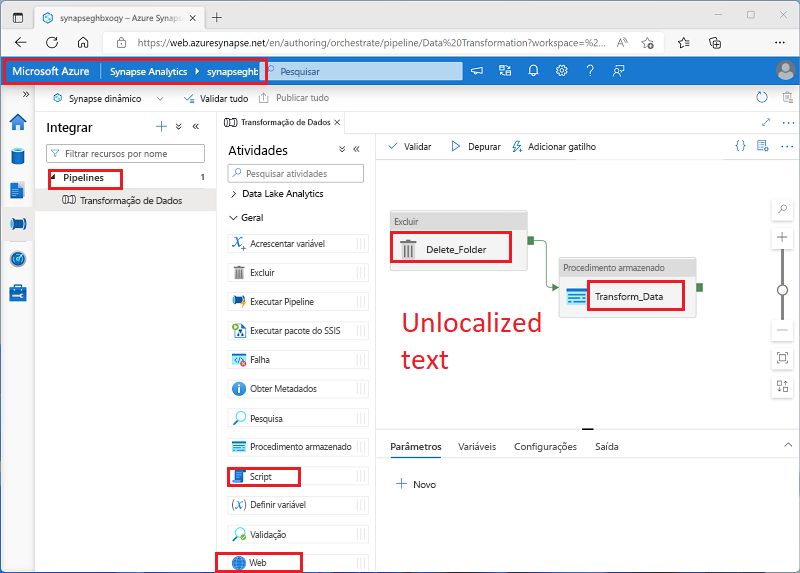